In [1]:
import numpy as np
import paddle as paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import os 

In [3]:
BUF_SIZE = 512
BATCH_SIZE = 128

train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.train(),
    buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE
)

test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.test(),buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE
)

train_data = paddle.dataset.mnist.train();
sampledata = next(train_data())
print(sampledata)

(array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1. 

In [4]:
def multilayer_perceptron(input):
    hiddle1 = fluid.layers.fc(input=input, size = 100, act = 'relu')
    hiddle2 = fluid.layers.fc(input= hiddle1, size= 100, act='relu')
    prediction = fluid.layers.fc(input= hiddle2, size=10, act='softmax')
    return prediction

In [5]:
image = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')
label = fluid.layers.data(name='label', shape=[1], dtype='int64')

In [6]:
predict = multilayer_perceptron(image)

In [7]:
cost = fluid.layers.cross_entropy(input=predict, label = label)

avg_cost = fluid.layers.mean(cost)

acc = fluid.layers.accuracy(input=predict, label=label)

In [8]:
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)

In [9]:
use_cuda = False
place = fluid.CPUPlace(0) if use_cuda else fluid.CPUPlace()

test_program = fluid.default_main_program().clone(for_test=True)
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

[]

In [10]:
feeder = fluid.DataFeeder(place=place, feed_list=[image, label])

In [13]:
all_train_iter = 0
all_train_iters = []
all_train_costs = []
all_train_accs = []

def draw_train_process(title, iters, costs, accs, label_cost, label_acc):
    plt.title(title, fontsize = 24)
    plt.xlabel('iter', fontsize = 20)
    plt.ylabel('cost/acc', fontsize = 20)
    plt.plot(iters, costs, color = 'red', label = label_cost)
    plt.plot(iters, accs, color = 'green', label = label_acc)
    plt.legend()
    plt.grid()
    plt.show()

Pass:0, Batch:0, Cost:0.20125, Accuracy:0.92188
Pass:0, Batch:200, Cost:0.15681, Accuracy:0.96094
Pass:0, Batch:400, Cost:0.09408, Accuracy:0.96094
Test:0, Cost:0.12644, Accuracy:0.95985
Pass:1, Batch:0, Cost:0.10992, Accuracy:0.96875
Pass:1, Batch:200, Cost:0.05742, Accuracy:0.98438
Pass:1, Batch:400, Cost:0.15523, Accuracy:0.94531
Test:1, Cost:0.11498, Accuracy:0.96341
save models to /Users/meininghang/hand.inference.model
训练模型保存完成！


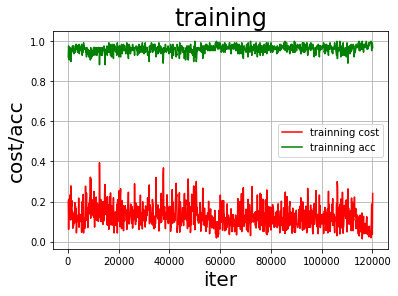

In [14]:
EPOCH_NUM=2
model_save_dir = "/Users/meininghang/hand.inference.model"
for pass_id in range(EPOCH_NUM):
    # 进行训练
    for batch_id, data in enumerate(train_reader()):                         #遍历train_reader
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),#运行主程序
                                        feed=feeder.feed(data),              #给模型喂入数据
                                        fetch_list=[avg_cost, acc])          #fetch 误差、准确率  
        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
        
        # 每200个batch打印一次信息  误差、准确率
        if batch_id % 200 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' %
                  (pass_id, batch_id, train_cost[0], train_acc[0]))

    # 进行测试
    test_accs = []
    test_costs = []
    #每训练一轮 进行一次测试
    for batch_id, data in enumerate(test_reader()):                         #遍历test_reader
        test_cost, test_acc = exe.run(program=test_program, #执行训练程序
                                      feed=feeder.feed(data),               #喂入数据
                                      fetch_list=[avg_cost, acc])           #fetch 误差、准确率
        test_accs.append(test_acc[0])                                       #每个batch的准确率
        test_costs.append(test_cost[0])                                     #每个batch的误差
        
       
    # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                         #每轮的平均误差
    test_acc = (sum(test_accs) / len(test_accs))                            #每轮的平均准确率
    print('Test:%d, Cost:%0.5f, Accuracy:%0.5f' % (pass_id, test_cost, test_acc))
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['image'],    #推理（inference）需要 feed 的数据
                                  [predict],    #保存推理（inference）结果的 Variables
                                  exe)             #executor 保存 inference model

print('训练模型保存完成！')
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

In [19]:
def load_image(file):
    im = Image.open(file).convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)
    #print(im)
    im = im / 255.0 * 2.0 - 1.0
    return im

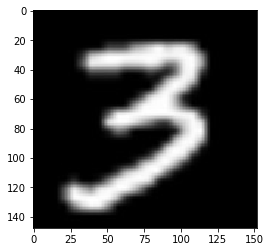

In [20]:
infer_path = '/Users/meininghang/Downloads/Unknown.png'
img = Image.open(infer_path)
plt.imshow(img)
plt.show()

In [21]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

In [22]:
with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names, fetch_targets] = fluid.io.load_inference_model(model_save_dir, infer_exe)
    img = load_image(infer_path)

    results = infer_exe.run(program=inference_program, feed={feed_target_names[0]: img}, fetch_list=fetch_targets)
    lab = np.argsort(results)
    print('该图片的预测结果的 label 为: %d' % lab[0][0][-1])

该图片的预测结果的 label 为: 3
